# Unit 3 Project: The Right Likelihood for the Job

**Task**:

Two parts:

1. Propose a data set that's compatible with a single variable likelihood from pymc. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror, and NONE of your priors can be a beta distribtuion
- Your likelihood CANNOT be a Bernoulli distribution nor a Binomial distribution.



In [ ]:
!pip install "preliz[full,notebook]"


import preliz as pz


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 13.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

# Introduction
In football the offense has 4 plays to get 10 yards. If they reach the 10 yard marker in those 4 plays they get what's called a first down. This means that the offense reached their 10 yard in 4 play goal and get another set of 4 plays to get 10 more yards. First downs per game isn't the greatest statistic to see how good a team is because there are so many factors other than the team being good that can change the number of first downs per game. It can be used to see which team has a more efficient offense. More first downs means an offense that can get yards easier in simple terms.

# Data Collection
In this project I wanted to look at first down per game during the 2023-24 NFL season for every team. On the site https://www.teamrankings.com/nfl/stat/first-downs-per-game?date=2024-02-12 I found the statistics for what I needed. I put all the numbers into a csv file and then graphed it below.

(array([3., 0., 5., 1., 8., 6., 3., 2., 1., 3.]),
 array([15.3 , 16.11, 16.92, 17.73, 18.54, 19.35, 20.16, 20.97, 21.78,
        22.59, 23.4 ]),
 <BarContainer object of 10 artists>)

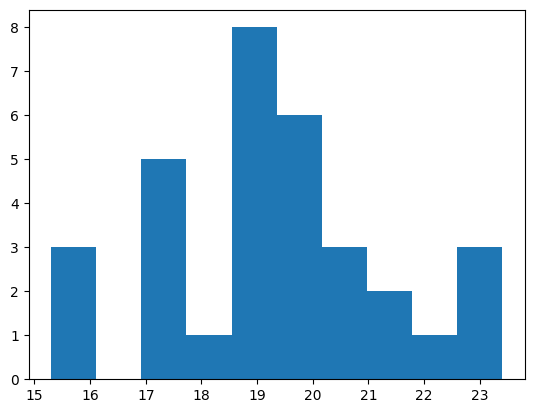

In [ ]:
url_data = 'https://raw.githubusercontent.com/vincewilliams1101/DataScience/refs/heads/main/unit3proj_data.csv'
data = pd.read_csv(url_data)
plt.hist(data)

# First Model
I started with a model that used a Normal graph because I thought that matched the shape of my data pretty well. There is an obvious parabola of the data with most of the teams having 19-20 first downs per game.

<Axes: >

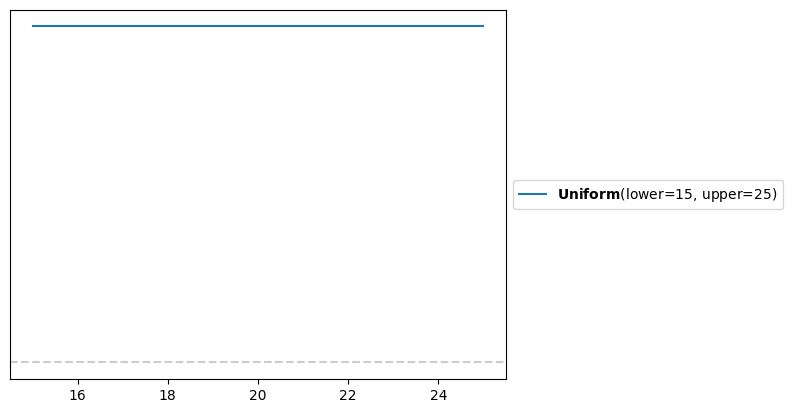

In [ ]:
pz.Uniform(15,25).plot_pdf()

<Axes: >

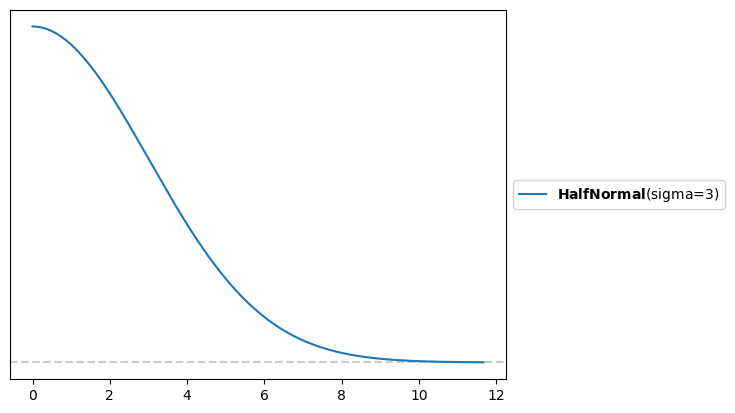

In [ ]:
pz.HalfNormal(sigma=3).plot_pdf()

In [ ]:
with pm.Model() as model_nfldata:
  m = pm.Uniform('mu', lower=15, upper=25)
  s = pm.HalfNormal('sigma', sigma=3)
  Y = pm.Normal('Y', mu = m, sigma=s, observed=data)
  idata = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

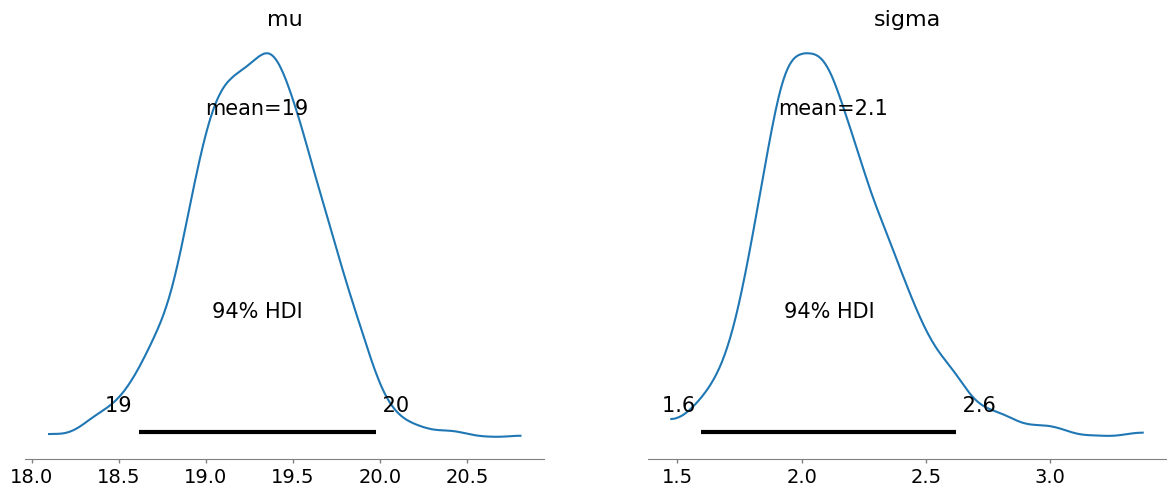

In [ ]:
az.plot_posterior(idata)

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

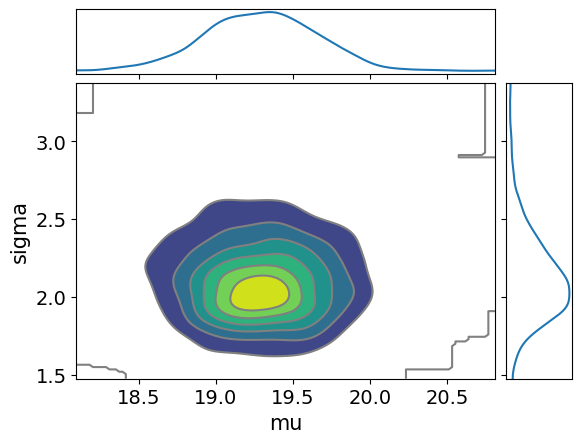

In [ ]:
az.plot_pair(idata, kind='kde', marginals=True)

In [ ]:
pm.sample_posterior_predictive(idata, model=model_nfldata, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

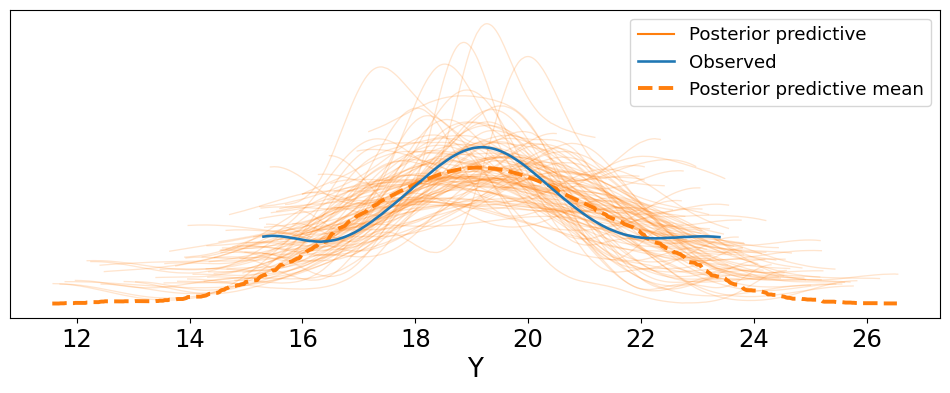

In [ ]:
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Second Model
The first model didn't work super well. I realized that I needed to account for a lot more outliers. If you look back at the graph of the observed data you can see that there are a lot of teams on either end of the graph at 16 first downs per game and at 23 first downs per game. To account for those outliers I chose a model that used a StudentT graph and I chose a lambda value (1/20) that would make my posterior predictive mean more accurate.

In [ ]:
with pm.Model() as model_nfldata2:
  m = pm.Uniform('m', lower=15, upper=25)
  s = pm.HalfNormal('s', sigma=1.5)
  v = pm.Exponential('v', lam=(1/20))
  y = pm.StudentT('y', mu=m, sigma=s, nu=v, observed=data)
  idata2 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.sample_posterior_predictive(idata2, model=model_nfldata2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(15.0, 25.0)

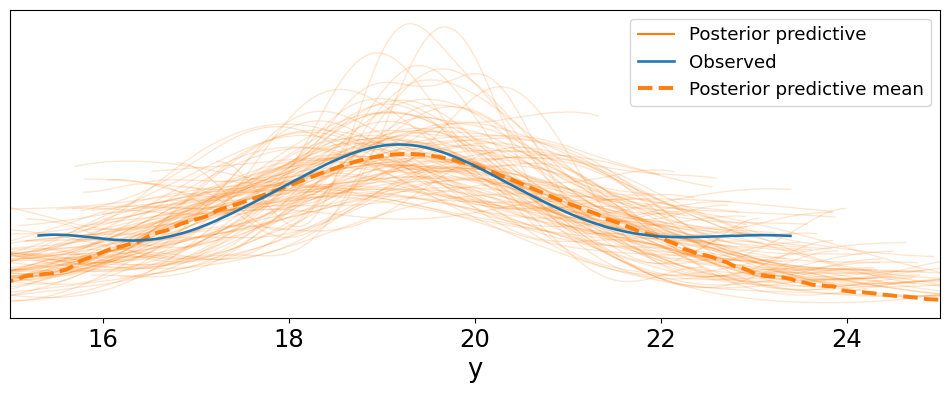

In [ ]:
ax = az.plot_ppc(idata2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(15,25)

# Conclusion
The second model that used a StudentT graph got me a posterior predictive mean very close to my observed data. With this model I can predict how many first downs per game a team might have. This is important because it can be a metric used to see how efficient a team's offense is. However, there are a lot of factors that might go into a teams first downs per game making the stat show less about how good the team actually is. For example, the Baltimore Ravens were the best team in the league based on their record (13-4) and had the MVP of the league as their quarterback. They were 7th in the league in first downs per game. This can be because of many different things including their offense being SO good that they needed less first downs to score when they were on offense.